## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import pickle

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load stock data
sector_df = pd.read_csv('sector_stocks.csv')
performance_df = pd.read_csv('stock_performance_summary.csv')
full_features = pd.read_csv('full_features_dataset.csv')

# Load price data
price_data = pd.read_pickle('price_data_all_stocks_cache.pkl')

# Load economic data
economic_data = pd.read_pickle('economic_data_cache.pkl')

# Rename columns for consistency
economic_data = economic_data.rename(columns={
    '^VIX': 'VIX',
    'CL=F': 'OIL_WTI',
    'DX-Y.NYB': 'USD_INDEX',
    'GC=F': 'GOLD'
})

print(f"Stocks available: {len(sector_df)}")
print(f"Economic indicators: {len(economic_data.columns)}")
print(f"Date range: {price_data.index[0]} to {price_data.index[-1]}")

Stocks available: 302
Economic indicators: 28
Date range: 2024-01-12 00:00:00 to 2026-01-09 00:00:00


## 2. Prepare Data and Build Prediction Model

In [3]:
# Extract adjusted close prices
if isinstance(price_data.columns, pd.MultiIndex):
    adj_close = price_data.xs('Close', level=0, axis=1)
else:
    adj_close = price_data

adj_close = adj_close.dropna(axis=1, how='all')

# Calculate forward returns (what we want to predict)
# We'll predict 1-month forward return
forward_returns_1m = adj_close.pct_change(periods=21).shift(-21)  # 1 month forward
forward_returns_3m = adj_close.pct_change(periods=63).shift(-63)  # 3 months forward

print(f"Stock prices shape: {adj_close.shape}")
print(f"Forward returns calculated")

Stock prices shape: (500, 301)
Forward returns calculated


In [4]:
# Process economic data and create features
economic_data_filled = economic_data.fillna(method='ffill')
economic_features = economic_data_filled.copy()

# Calculate derived features
if 'M2' in economic_features.columns:
    economic_features['M2_YoY_Growth'] = economic_features['M2'].pct_change(252) * 100
    economic_features['M2_QoQ_Growth'] = economic_features['M2'].pct_change(63) * 100

if 'CPI' in economic_features.columns:
    economic_features['Inflation_YoY'] = economic_features['CPI'].pct_change(252) * 100

if 'CORE_CPI' in economic_features.columns:
    economic_features['Core_Inflation_YoY'] = economic_features['CORE_CPI'].pct_change(252) * 100

if 'GDP' in economic_features.columns:
    economic_features['GDP_Growth'] = economic_features['GDP'].pct_change(63) * 100

if 'INDUSTRIAL_PROD' in economic_features.columns:
    economic_features['Ind_Prod_Growth'] = economic_features['INDUSTRIAL_PROD'].pct_change(252) * 100

if 'RETAIL_SALES' in economic_features.columns:
    economic_features['Retail_Sales_Growth'] = economic_features['RETAIL_SALES'].pct_change(252) * 100

if 'TREASURY_10Y' in economic_features.columns and 'TREASURY_2Y' in economic_features.columns:
    economic_features['Yield_Curve_Slope'] = economic_features['TREASURY_10Y'] - economic_features['TREASURY_2Y']

if 'TREASURY_10Y' in economic_features.columns and 'TREASURY_5Y' in economic_features.columns:
    economic_features['Yield_Curve_5Y10Y'] = economic_features['TREASURY_10Y'] - economic_features['TREASURY_5Y']

if 'FED_FUNDS' in economic_features.columns:
    economic_features['FED_FUNDS_Change'] = economic_features['FED_FUNDS'].diff()

if 'OIL_WTI' in economic_features.columns:
    economic_features['Oil_Return_1M'] = economic_features['OIL_WTI'].pct_change(21) * 100
    economic_features['Oil_Return_3M'] = economic_features['OIL_WTI'].pct_change(63) * 100

if 'USD_INDEX' in economic_features.columns:
    economic_features['USD_Return_1M'] = economic_features['USD_INDEX'].pct_change(21) * 100
    economic_features['USD_Return_3M'] = economic_features['USD_INDEX'].pct_change(63) * 100

if 'GOLD' in economic_features.columns:
    economic_features['Gold_Return_1M'] = economic_features['GOLD'].pct_change(21) * 100
    economic_features['Gold_Return_3M'] = economic_features['GOLD'].pct_change(63) * 100

if 'HOUSING_STARTS' in economic_features.columns:
    economic_features['Housing_Growth'] = economic_features['HOUSING_STARTS'].pct_change(63) * 100

if 'CONSUMER_SENTIMENT' in economic_features.columns:
    economic_features['Sentiment_Change'] = economic_features['CONSUMER_SENTIMENT'].diff()

print(f"Economic features shape: {economic_features.shape}")
print(f"Total features: {len(economic_features.columns)}")

Economic features shape: (511, 46)
Total features: 46


In [5]:
# Align economic data with stock data (daily frequency)
# We'll use forward fill to propagate monthly/quarterly economic data to daily
economic_daily = economic_features.reindex(adj_close.index, method='ffill')

print(f"Economic data aligned to daily frequency: {economic_daily.shape}")
print(f"Missing data:")
print(economic_daily.isnull().sum().sum())

Economic data aligned to daily frequency: (500, 46)
Missing data:
1847


## 3. Train Prediction Models by Sector

In [6]:
# Train separate models for each sector
from sklearn.model_selection import train_test_split

sector_models = {}
sector_scalers = {}
sector_features = {}

for sector in sector_df['Sector_Code'].unique():
    print(f"\nTraining model for {sector}...")
    
    # Get stocks in this sector
    sector_stocks = sector_df[sector_df['Sector_Code'] == sector]['Symbol'].tolist()
    available_stocks = [s for s in sector_stocks if s in adj_close.columns]
    
    if len(available_stocks) == 0:
        print(f"  No stocks available for {sector}")
        continue
    
    # Create training data
    X_list = []
    y_list = []
    
    for stock in available_stocks:
        # Get forward returns for this stock
        y_stock = forward_returns_1m[stock].copy()
        
        # Align with economic data
        combined_data = pd.concat([y_stock, economic_daily], axis=1)
        combined_data = combined_data.dropna()
        
        if len(combined_data) > 50:  # Need sufficient data
            X_list.append(combined_data.iloc[:, 1:])  # Economic features
            y_list.append(combined_data.iloc[:, 0])   # Returns
    
    if len(X_list) == 0:
        print(f"  Insufficient data for {sector}")
        continue
    
    # Combine all stocks in sector
    X_sector = pd.concat(X_list, axis=0)
    y_sector = pd.concat(y_list, axis=0)
    
    # Remove features with zero variance or too many NaNs
    valid_features = []
    for col in X_sector.columns:
        if X_sector[col].std() > 0 and X_sector[col].notna().sum() > len(X_sector) * 0.5:
            valid_features.append(col)
    
    X_sector = X_sector[valid_features].fillna(X_sector[valid_features].median())
    
    # Store feature names
    sector_features[sector] = valid_features
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sector)
    sector_scalers[sector] = scaler
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_scaled, y_sector)
    sector_models[sector] = rf_model
    
    # Evaluate
    train_score = rf_model.score(X_scaled, y_sector)
    print(f"  {sector}: {len(available_stocks)} stocks, {len(X_sector)} samples, R² = {train_score:.4f}")

print(f"\nTrained models for {len(sector_models)} sectors")


Training model for XLK...
  XLK: 60 stocks, 14340 samples, R² = 0.3248

Training model for XLV...
  XLV: 63 stocks, 15057 samples, R² = 0.1472

Training model for XLF...
  XLF: 65 stocks, 15535 samples, R² = 0.3715

Training model for XLI...
  XLI: 66 stocks, 15774 samples, R² = 0.3196

Training model for XLY...
  XLY: 48 stocks, 11472 samples, R² = 0.2941

Trained models for 5 sectors


## 4. Get Current Economic Factor Values

In [7]:
# Get most recent economic factor values
latest_economic_data = economic_features.iloc[-1].copy()

# Create a DataFrame for display
current_factors = pd.DataFrame({
    'Factor': latest_economic_data.index,
    'Current_Value': latest_economic_data.values
})

print("CURRENT ECONOMIC FACTOR VALUES")
print("=" * 80)
print(f"As of: {economic_features.index[-1].strftime('%Y-%m-%d')}")
print("\n")
print(current_factors.to_string(index=False))

CURRENT ECONOMIC FACTOR VALUES
As of: 2025-12-04


             Factor  Current_Value
                 M2   2.229810e+04
          FED_FUNDS   4.090000e+00
       TREASURY_10Y   4.120000e+00
        TREASURY_2Y   3.550000e+00
        TREASURY_5Y   3.680000e+00
                GDP   3.048573e+04
    INDUSTRIAL_PROD   1.014279e+02
      CAPACITY_UTIL   7.586650e+01
                CPI   3.243680e+02
                PPI   2.623440e+02
                PCE   2.115220e+04
           CORE_CPI   3.305420e+02
       UNEMPLOYMENT   4.400000e+00
    NONFARM_PAYROLL   1.594880e+05
   LABOR_FORCE_PART   6.240000e+01
     INITIAL_CLAIMS   2.240000e+05
       RETAIL_SALES   7.326330e+05
 CONSUMER_SENTIMENT   5.360000e+01
    PERSONAL_INCOME   2.639750e+04
     HOUSING_STARTS   1.307000e+03
     NEW_HOME_SALES   8.000000e+02
EXISTING_HOME_SALES   4.100000e+06
   CORP_BOND_SPREAD   1.690000e+00
      CREDIT_SPREAD   2.810000e+00
                VIX   1.578000e+01
            OIL_WTI   5.967000e+01
    

## 5. Stock Price Prediction Function

In [8]:
def predict_stock_price(symbol, 
                       time_horizon_days=21,
                       economic_changes=None,
                       show_details=True):
    """
    Predict stock price based on economic factor scenarios.
    
    Parameters:
    -----------
    symbol : str
        Stock ticker symbol
    time_horizon_days : int
        Prediction horizon in days (default: 21 = 1 month)
    economic_changes : dict
        Dictionary of economic factor changes from current values
        e.g., {'VIX': -2.0, 'OIL_WTI': 5.0} means VIX decreases by 2, oil increases by 5
    show_details : bool
        Whether to print detailed information
    
    Returns:
    --------
    dict with prediction results
    """
    
    # Check if stock exists
    if symbol not in adj_close.columns:
        available = ', '.join(list(adj_close.columns[:10])) + '...'
        return {"error": f"Stock {symbol} not found. Available stocks: {available}"}
    
    # Get stock's sector
    stock_info = sector_df[sector_df['Symbol'] == symbol]
    if len(stock_info) == 0:
        return {"error": f"Stock {symbol} not in sector database"}
    
    sector = stock_info['Sector_Code'].iloc[0]
    sector_name = stock_info['Sector'].iloc[0]
    
    if sector not in sector_models:
        return {"error": f"No trained model for sector {sector}"}
    
    # Get current price
    current_price = adj_close[symbol].iloc[-1]
    
    # Prepare economic features for prediction
    future_factors = latest_economic_data.copy()
    
    # Apply user-specified changes
    if economic_changes:
        for factor, change in economic_changes.items():
            if factor in future_factors.index:
                future_factors[factor] += change
    
    # Get only features used by this sector's model
    model_features = sector_features[sector]
    X_pred = future_factors[model_features].values.reshape(1, -1)
    
    # Handle any remaining NaN values
    X_pred_df = pd.DataFrame(X_pred, columns=model_features)
    X_pred_df = X_pred_df.fillna(X_pred_df.median())
    
    # Scale features
    X_pred_scaled = sector_scalers[sector].transform(X_pred_df)
    
    # Predict 1-month return
    predicted_return = sector_models[sector].predict(X_pred_scaled)[0]
    
    # Adjust for time horizon (scale linearly, rough approximation)
    adjusted_return = predicted_return * (time_horizon_days / 21)
    
    # Calculate predicted price
    predicted_price = current_price * (1 + adjusted_return)
    
    # Calculate price change
    price_change = predicted_price - current_price
    percent_change = (predicted_price / current_price - 1) * 100
    
    # Get feature importance for this prediction
    feature_importance = pd.DataFrame({
        'Feature': model_features,
        'Importance': sector_models[sector].feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    result = {
        'symbol': symbol,
        'sector': sector_name,
        'current_price': current_price,
        'predicted_price': predicted_price,
        'price_change': price_change,
        'percent_change': percent_change,
        'predicted_return': adjusted_return,
        'time_horizon_days': time_horizon_days,
        'economic_changes': economic_changes or {},
        'top_factors': feature_importance
    }
    
    if show_details:
        print("=" * 80)
        print(f"STOCK PRICE PREDICTION: {symbol}")
        print("=" * 80)
        print(f"Sector: {sector_name} ({sector})")
        print(f"Time Horizon: {time_horizon_days} days")
        print(f"\nCurrent Price: ${current_price:.2f}")
        print(f"Predicted Price: ${predicted_price:.2f}")
        print(f"Expected Change: ${price_change:.2f} ({percent_change:+.2f}%)")
        print(f"\nPredicted Return: {adjusted_return*100:.2f}%")
        
        if economic_changes:
            print(f"\nEconomic Factor Changes Applied:")
            for factor, change in economic_changes.items():
                print(f"  {factor}: {change:+.2f}")
        
        print(f"\nTop 10 Influencing Factors:")
        for idx, row in feature_importance.iterrows():
            print(f"  {row['Feature']:30s} {row['Importance']:.4f}")
        
        print("=" * 80)
    
    return result

## 6. Interactive Prediction Tool

In [9]:
# Example 1: Predict with default economic factors
symbol = "AAPL"  # Change this to any stock symbol from your dataset

result = predict_stock_price(symbol, time_horizon_days=21)

STOCK PRICE PREDICTION: AAPL
Sector: Technology (XLK)
Time Horizon: 21 days

Current Price: $259.37
Predicted Price: $262.04
Expected Change: $2.67 (+1.03%)

Predicted Return: 1.03%

Top 10 Influencing Factors:
  CORP_BOND_SPREAD               0.3978
  VIX                            0.2013
  Ind_Prod_Growth                0.1866
  USD_INDEX                      0.0425
  USD_Return_3M                  0.0421
  Oil_Return_1M                  0.0279
  Gold_Return_3M                 0.0188
  OIL_WTI                        0.0174
  USD_Return_1M                  0.0145
  Gold_Return_1M                 0.0142


In [10]:
# Example 2: Predict with custom economic scenario
# Let's assume VIX decreases (less volatility) and oil prices increase

custom_scenario = {
    'VIX': -3.0,           # VIX decreases by 3 points (bullish)
    'OIL_WTI': 10.0,       # Oil price increases by $10
    'FED_FUNDS': 0.5,      # Fed funds rate increases by 0.5%
    'USD_INDEX': -2.0,     # Dollar weakens by 2 points
}

result_custom = predict_stock_price(
    symbol="MSFT",
    time_horizon_days=63,  # 3 months
    economic_changes=custom_scenario
)

STOCK PRICE PREDICTION: MSFT
Sector: Technology (XLK)
Time Horizon: 63 days

Current Price: $479.28
Predicted Price: $458.15
Expected Change: $-21.13 (-4.41%)

Predicted Return: -4.41%

Economic Factor Changes Applied:
  VIX: -3.00
  OIL_WTI: +10.00
  FED_FUNDS: +0.50
  USD_INDEX: -2.00

Top 10 Influencing Factors:
  CORP_BOND_SPREAD               0.3978
  VIX                            0.2013
  Ind_Prod_Growth                0.1866
  USD_INDEX                      0.0425
  USD_Return_3M                  0.0421
  Oil_Return_1M                  0.0279
  Gold_Return_3M                 0.0188
  OIL_WTI                        0.0174
  USD_Return_1M                  0.0145
  Gold_Return_1M                 0.0142


## 7. Scenario Comparison Tool

In [11]:
def compare_scenarios(symbol, scenarios, time_horizon_days=21):
    """
    Compare multiple economic scenarios for a given stock.
    
    Parameters:
    -----------
    symbol : str
        Stock ticker symbol
    scenarios : dict
        Dictionary of scenario_name: economic_changes
    time_horizon_days : int
        Prediction horizon in days
    """
    
    results = []
    
    for scenario_name, changes in scenarios.items():
        result = predict_stock_price(
            symbol=symbol,
            time_horizon_days=time_horizon_days,
            economic_changes=changes,
            show_details=False
        )
        
        if 'error' not in result:
            results.append({
                'Scenario': scenario_name,
                'Predicted_Price': result['predicted_price'],
                'Price_Change': result['price_change'],
                'Percent_Change': result['percent_change']
            })
    
    if not results:
        print("No valid results")
        return None
    
    comparison_df = pd.DataFrame(results)
    
    # Display results
    print("=" * 80)
    print(f"SCENARIO COMPARISON: {symbol}")
    print("=" * 80)
    print(f"Current Price: ${result['current_price']:.2f}")
    print(f"Time Horizon: {time_horizon_days} days\n")
    print(comparison_df.to_string(index=False))
    print("=" * 80)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Predicted prices
    ax1 = axes[0]
    colors = ['green' if x > 0 else 'red' for x in comparison_df['Price_Change']]
    ax1.barh(comparison_df['Scenario'], comparison_df['Predicted_Price'], color=colors, alpha=0.7, edgecolor='black')
    ax1.axvline(x=result['current_price'], color='blue', linestyle='--', linewidth=2, label='Current Price')
    ax1.set_xlabel('Predicted Price ($)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{symbol} - Predicted Prices by Scenario', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Percent changes
    ax2 = axes[1]
    colors2 = ['green' if x > 0 else 'red' for x in comparison_df['Percent_Change']]
    ax2.barh(comparison_df['Scenario'], comparison_df['Percent_Change'], color=colors2, alpha=0.7, edgecolor='black')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Expected Return (%)', fontsize=12, fontweight='bold')
    ax2.set_title(f'{symbol} - Expected Returns by Scenario', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

SCENARIO COMPARISON: AAPL
Current Price: $259.37
Time Horizon: 63 days

           Scenario  Predicted_Price  Price_Change  Percent_Change
Current (No Change)       267.393545      8.023550        3.093477
    Bullish Economy       248.072815    -11.297180       -4.355623
    Bearish Economy       320.641279     61.271284       23.623119
       Rising Rates       267.401563      8.031568        3.096568
          Oil Shock       298.021675     38.651680       14.902140
       Housing Boom       267.210606      7.840611        3.022944


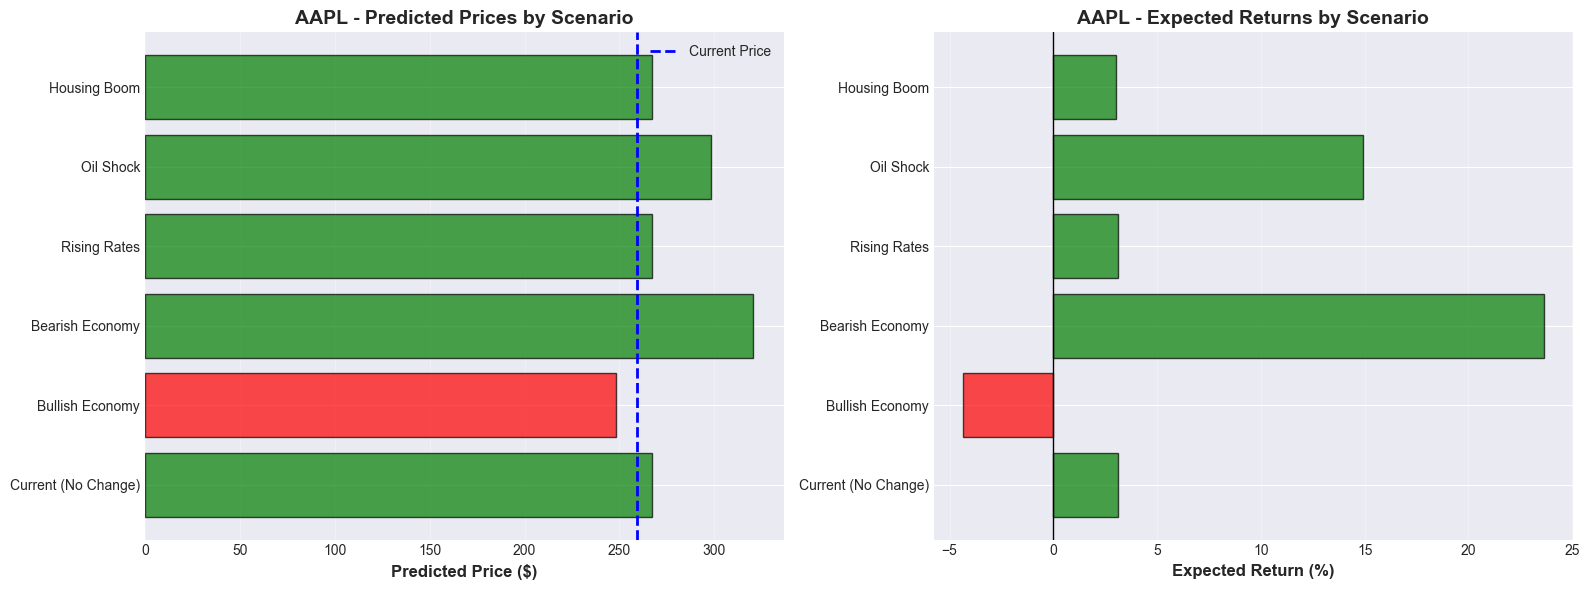

In [12]:
# Example: Compare multiple scenarios
scenarios = {
    'Current (No Change)': {},
    
    'Bullish Economy': {
        'VIX': -5.0,
        'GDP_Growth': 1.0,
        'UNEMPLOYMENT': -0.5,
        'CONSUMER_SENTIMENT': 5.0,
    },
    
    'Bearish Economy': {
        'VIX': 10.0,
        'GDP_Growth': -1.0,
        'UNEMPLOYMENT': 0.5,
        'CREDIT_SPREAD': 0.5,
    },
    
    'Rising Rates': {
        'FED_FUNDS': 1.0,
        'TREASURY_10Y': 0.5,
        'TREASURY_2Y': 0.75,
    },
    
    'Oil Shock': {
        'OIL_WTI': 30.0,
        'Inflation_YoY': 2.0,
        'VIX': 5.0,
    },
    
    'Housing Boom': {
        'HOUSING_STARTS': 100.0,
        'NEW_HOME_SALES': 50.0,
        'CONSUMER_SENTIMENT': 10.0,
    }
}

comparison = compare_scenarios(
    symbol="AAPL",
    scenarios=scenarios,
    time_horizon_days=63  # 3 months
)

## 8. Batch Prediction for Multiple Stocks

In [13]:
def predict_portfolio(symbols, economic_changes=None, time_horizon_days=21):
    """
    Predict prices for multiple stocks under the same economic scenario.
    """
    
    results = []
    
    for symbol in symbols:
        result = predict_stock_price(
            symbol=symbol,
            time_horizon_days=time_horizon_days,
            economic_changes=economic_changes,
            show_details=False
        )
        
        if 'error' not in result:
            results.append({
                'Symbol': symbol,
                'Sector': result['sector'],
                'Current_Price': result['current_price'],
                'Predicted_Price': result['predicted_price'],
                'Expected_Return_%': result['percent_change']
            })
    
    portfolio_df = pd.DataFrame(results).sort_values('Expected_Return_%', ascending=False)
    
    print("=" * 80)
    print(f"PORTFOLIO PREDICTIONS")
    print("=" * 80)
    print(f"Time Horizon: {time_horizon_days} days")
    if economic_changes:
        print(f"Economic Scenario Applied:")
        for factor, change in economic_changes.items():
            print(f"  {factor}: {change:+.2f}")
    print("\n")
    print(portfolio_df.to_string(index=False))
    print("=" * 80)
    
    return portfolio_df

In [14]:
# Example: Predict top stocks under bullish scenario
top_stocks = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'JPM', 'JNJ', 'V']

bullish_scenario = {
    'VIX': -5.0,
    'GDP_Growth': 1.5,
    'CONSUMER_SENTIMENT': 10.0,
    'UNEMPLOYMENT': -0.3,
}

portfolio_predictions = predict_portfolio(
    symbols=top_stocks,
    economic_changes=bullish_scenario,
    time_horizon_days=21
)

PORTFOLIO PREDICTIONS
Time Horizon: 21 days
Economic Scenario Applied:
  VIX: -5.00
  GDP_Growth: +1.50
  CONSUMER_SENTIMENT: +10.00
  UNEMPLOYMENT: -0.30


Symbol                 Sector  Current_Price  Predicted_Price  Expected_Return_%
   JPM              Financial     329.190002       346.733589           5.329319
  AMZN Consumer Discretionary     247.380005       256.858257           3.831454
  TSLA Consumer Discretionary     445.010010       462.060365           3.831454
   JNJ             Healthcare     204.389999       211.856989           3.653305
  AAPL             Technology     259.369995       255.604268          -1.451874
  MSFT             Technology     479.279999       472.321455          -1.451874
  NVDA             Technology     184.860001       182.176066          -1.451874


## 9. Available Stocks Reference

In [15]:
# Display available stocks by sector
print("AVAILABLE STOCKS BY SECTOR")
print("=" * 80)

for sector_code in sorted(sector_df['Sector_Code'].unique()):
    sector_name = sector_df[sector_df['Sector_Code'] == sector_code]['Sector'].iloc[0]
    stocks = sector_df[sector_df['Sector_Code'] == sector_code]['Symbol'].tolist()
    stocks = [s for s in stocks if s in adj_close.columns]
    
    print(f"\n{sector_name} ({sector_code}): {len(stocks)} stocks")
    print(f"  {', '.join(stocks[:20])}{'...' if len(stocks) > 20 else ''}")

AVAILABLE STOCKS BY SECTOR

Financial (XLF): 65 stocks
  JPM, BAC, WFC, MS, GS, C, SPGI, BLK, AXP, SCHW, BX, CB, MMC, PGR, KKR, ICE, CME, AFL, USB, PNC...

Industrial (XLI): 66 stocks
  GE, CAT, RTX, HON, UNP, ETN, ADP, BA, DE, LMT, UPS, GEV, TT, GD, PH, WM, TDG, ITW, MMM, CSX...

Technology (XLK): 60 stocks
  AAPL, MSFT, NVDA, AVGO, CRM, ORCL, CSCO, ACN, AMD, ADBE, INTU, IBM, TXN, QCOM, NOW, AMAT, PANW, MU, ADI, LRCX...

Healthcare (XLV): 63 stocks
  UNH, JNJ, LLY, ABBV, MRK, TMO, ABT, DHR, PFE, AMGN, BSX, ISRG, SYK, GILD, VRTX, BMY, MDT, ELV, CI, CVS...

Consumer Discretionary (XLY): 48 stocks
  AMZN, TSLA, HD, MCD, NKE, BKNG, LOW, SBUX, TJX, CMG, ORLY, MAR, GM, ABNB, F, HLT, AZO, ROST, DHI, LEN...


## 10. Economic Factors Reference Guide

In [16]:
# Create a reference guide for economic factors
factor_guide = {
    'VIX': 'Market Volatility Index (lower = bullish)',
    'OIL_WTI': 'Crude Oil Price ($/barrel)',
    'USD_INDEX': 'US Dollar Strength Index',
    'GOLD': 'Gold Price ($/oz)',
    'FED_FUNDS': 'Federal Funds Rate (%)',
    'TREASURY_10Y': '10-Year Treasury Yield (%)',
    'TREASURY_2Y': '2-Year Treasury Yield (%)',
    'GDP_Growth': 'GDP Growth Rate (%)',
    'Inflation_YoY': 'Year-over-Year Inflation (%)',
    'UNEMPLOYMENT': 'Unemployment Rate (%)',
    'CONSUMER_SENTIMENT': 'Consumer Sentiment Index',
    'HOUSING_STARTS': 'Housing Starts (thousands)',
    'CREDIT_SPREAD': 'Corporate Credit Spread (%)',
    'CORP_BOND_SPREAD': 'Corporate Bond Spread over 10Y Treasury (%)',
    'M2_YoY_Growth': 'Money Supply Growth (%)',
    'RETAIL_SALES': 'Retail Sales ($ millions)',
}

print("\nECONOMIC FACTORS REFERENCE GUIDE")
print("=" * 80)
print("Use these factor names when creating economic scenarios:\n")
for factor, description in factor_guide.items():
    current_val = latest_economic_data.get(factor, 'N/A')
    if pd.notna(current_val):
        print(f"{factor:25s} Current: {current_val:>10.2f}  - {description}")
    else:
        print(f"{factor:25s} Current: {'N/A':>10s}  - {description}")


ECONOMIC FACTORS REFERENCE GUIDE
Use these factor names when creating economic scenarios:

VIX                       Current:      15.78  - Market Volatility Index (lower = bullish)
OIL_WTI                   Current:      59.67  - Crude Oil Price ($/barrel)
USD_INDEX                 Current:      98.99  - US Dollar Strength Index
GOLD                      Current:    4211.80  - Gold Price ($/oz)
FED_FUNDS                 Current:       4.09  - Federal Funds Rate (%)
TREASURY_10Y              Current:       4.12  - 10-Year Treasury Yield (%)
TREASURY_2Y               Current:       3.55  - 2-Year Treasury Yield (%)
GDP_Growth                Current:       0.00  - GDP Growth Rate (%)
Inflation_YoY             Current:       2.13  - Year-over-Year Inflation (%)
UNEMPLOYMENT              Current:       4.40  - Unemployment Rate (%)
CONSUMER_SENTIMENT        Current:      53.60  - Consumer Sentiment Index
HOUSING_STARTS            Current:    1307.00  - Housing Starts (thousands)
CREDIT_SP

## 11. Economic Factor Impact Analysis by Sector

ECONOMIC FACTOR IMPACT BY SECTOR

XLK - Technology
--------------------------------------------------------------------------------
          Factor  Importance
CORP_BOND_SPREAD    0.397807
             VIX    0.201336
 Ind_Prod_Growth    0.186551
       USD_INDEX    0.042522
   USD_Return_3M    0.042063
   Oil_Return_1M    0.027892
  Gold_Return_3M    0.018790
         OIL_WTI    0.017443
   USD_Return_1M    0.014468
  Gold_Return_1M    0.014181

XLV - Healthcare
--------------------------------------------------------------------------------
        Factor  Importance
     USD_INDEX    0.139492
       OIL_WTI    0.094598
 USD_Return_1M    0.089526
          GOLD    0.075714
 USD_Return_3M    0.064484
 CAPACITY_UTIL    0.061282
 Oil_Return_3M    0.054254
           VIX    0.046887
NEW_HOME_SALES    0.046109
Gold_Return_1M    0.044414

XLF - Financial
--------------------------------------------------------------------------------
             Factor  Importance
      M2_QoQ_Growth    

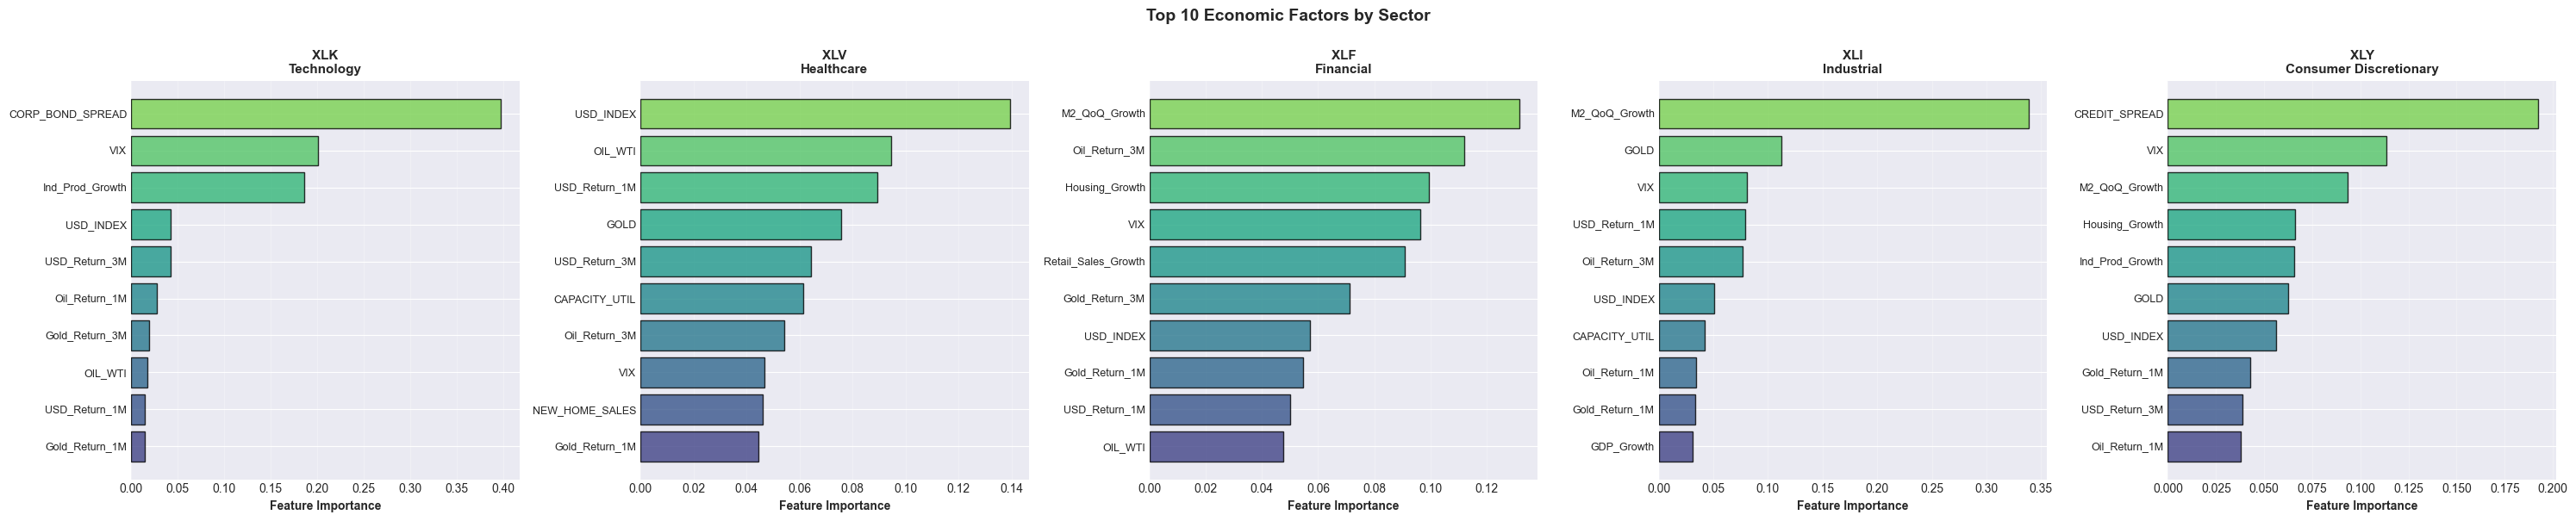

In [17]:
# Analyze which economic factors impact each sector the most
print("=" * 80)
print("ECONOMIC FACTOR IMPACT BY SECTOR")
print("=" * 80)

sector_factor_importance = {}

for sector, model in sector_models.items():
    features = sector_features[sector]
    importances = model.feature_importances_
    
    # Get top 10 factors for this sector
    factor_df = pd.DataFrame({
        'Factor': features,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(10)
    
    sector_factor_importance[sector] = factor_df
    
    sector_name = sector_df[sector_df['Sector_Code'] == sector]['Sector'].iloc[0]
    print(f"\n{sector} - {sector_name}")
    print("-" * 80)
    print(factor_df.to_string(index=False))

# Visualize sector-specific impacts
n_sectors = len(sector_models)
fig, axes = plt.subplots(1, n_sectors, figsize=(6*n_sectors, 6))

if n_sectors == 1:
    axes = [axes]

for idx, (sector, factor_df) in enumerate(sector_factor_importance.items()):
    ax = axes[idx]
    
    # Sort for visualization
    factor_sorted = factor_df.sort_values('Importance', ascending=True)
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(factor_sorted)))
    y_pos = range(len(factor_sorted))
    
    ax.barh(y_pos, factor_sorted['Importance'], color=colors, edgecolor='black', alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(factor_sorted['Factor'], fontsize=9)
    ax.set_xlabel('Feature Importance', fontsize=10, fontweight='bold')
    
    sector_name = sector_df[sector_df['Sector_Code'] == sector]['Sector'].iloc[0]
    ax.set_title(f'{sector}\n{sector_name}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Top 10 Economic Factors by Sector', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)

## 12. Sensitivity Analysis - How Economic Changes Impact Predictions

SENSITIVITY ANALYSIS: AAPL (Technology)
Baseline Expected Return: 1.03%
Testing +1.0 unit change in each factor

          Factor  Impact_Up  Impact_Down  Avg_Abs_Impact Direction
 Ind_Prod_Growth  -0.108294   -10.428802        5.268548  Negative
CORP_BOND_SPREAD   5.526982     0.000000        2.763491  Positive
             VIX   0.071260    -2.483033        1.277147  Positive
       USD_INDEX   0.097969    -2.231982        1.164976  Positive
   USD_Return_3M   0.410609    -0.223783        0.317196  Positive
         OIL_WTI  -0.239356     0.013209        0.126283  Negative
  Gold_Return_1M  -0.079308     0.060899        0.070104  Negative
  Gold_Return_3M  -0.019692    -0.056013        0.037852  Negative
   USD_Return_1M   0.058387     0.000000        0.029194  Positive
   Oil_Return_1M  -0.041983     0.006658        0.024321  Negative


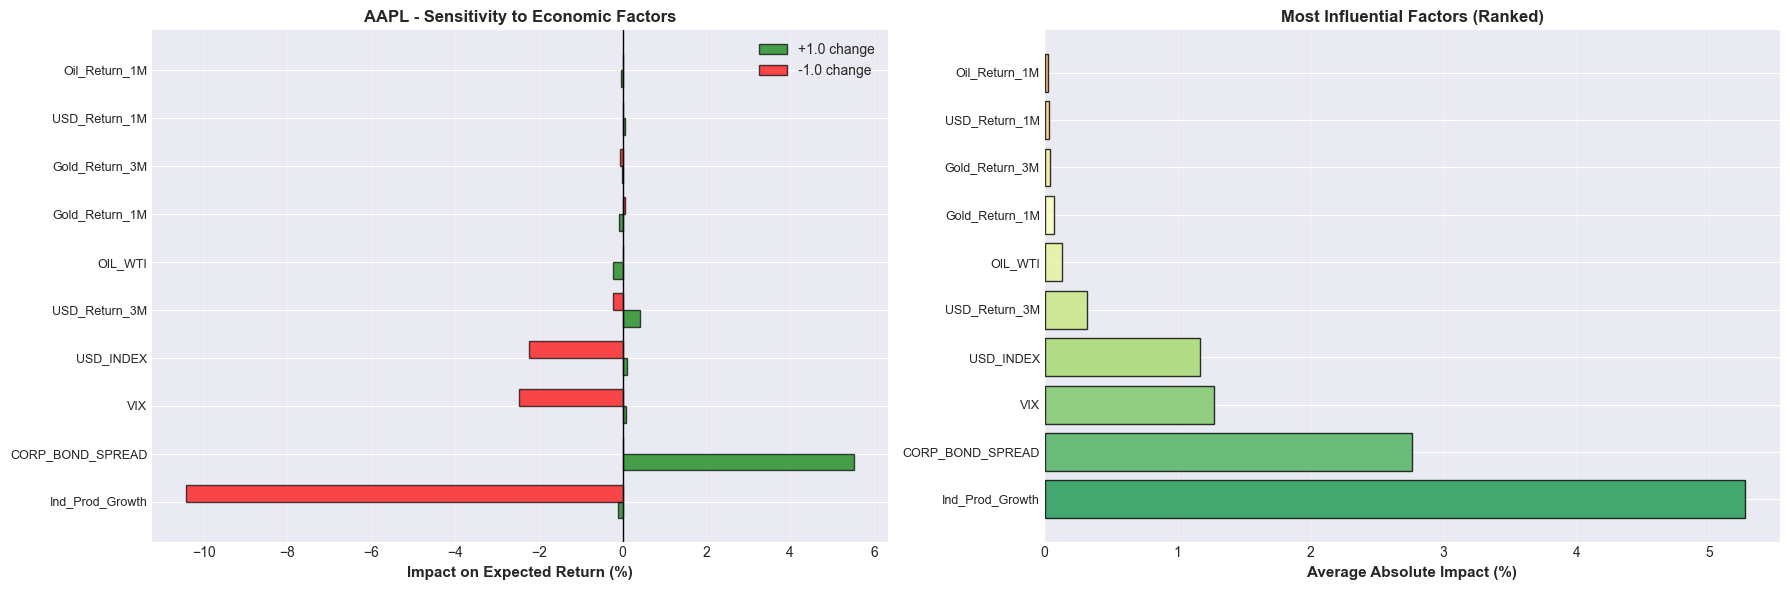

In [18]:
def sensitivity_analysis(symbol, factors_to_test=None, change_magnitude=1.0):
    """
    Analyze how sensitive a stock's prediction is to changes in economic factors.
    
    Parameters:
    -----------
    symbol : str
        Stock ticker symbol
    factors_to_test : list
        List of factors to test. If None, tests top 10 factors for the stock's sector
    change_magnitude : float
        Magnitude of change to test (positive and negative)
    
    Returns:
    --------
    DataFrame with sensitivity results
    """
    
    # Get baseline prediction
    baseline = predict_stock_price(symbol, time_horizon_days=21, show_details=False)
    
    if 'error' in baseline:
        print(baseline['error'])
        return None
    
    baseline_return = baseline['percent_change']
    sector = baseline['sector']
    
    # Determine which factors to test
    if factors_to_test is None:
        # Use top factors from the sector model
        sector_code = sector_df[sector_df['Symbol'] == symbol]['Sector_Code'].iloc[0]
        if sector_code in sector_factor_importance:
            factors_to_test = sector_factor_importance[sector_code]['Factor'].head(10).tolist()
        else:
            print(f"No factor importance data for sector {sector_code}")
            return None
    
    # Test each factor
    sensitivity_results = []
    
    for factor in factors_to_test:
        # Test positive change
        result_up = predict_stock_price(
            symbol,
            time_horizon_days=21,
            economic_changes={factor: change_magnitude},
            show_details=False
        )
        
        # Test negative change
        result_down = predict_stock_price(
            symbol,
            time_horizon_days=21,
            economic_changes={factor: -change_magnitude},
            show_details=False
        )
        
        if 'error' not in result_up and 'error' not in result_down:
            impact_up = result_up['percent_change'] - baseline_return
            impact_down = result_down['percent_change'] - baseline_return
            avg_impact = (abs(impact_up) + abs(impact_down)) / 2
            
            sensitivity_results.append({
                'Factor': factor,
                'Impact_Up': impact_up,
                'Impact_Down': impact_down,
                'Avg_Abs_Impact': avg_impact,
                'Direction': 'Positive' if impact_up > 0 else 'Negative'
            })
    
    sensitivity_df = pd.DataFrame(sensitivity_results).sort_values('Avg_Abs_Impact', ascending=False)
    
    # Display results
    print("=" * 80)
    print(f"SENSITIVITY ANALYSIS: {symbol} ({sector})")
    print("=" * 80)
    print(f"Baseline Expected Return: {baseline_return:.2f}%")
    print(f"Testing {change_magnitude:+.1f} unit change in each factor\n")
    print(sensitivity_df.to_string(index=False))
    print("=" * 80)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot 1: Impact comparison
    top_factors = sensitivity_df.head(10)
    x = range(len(top_factors))
    width = 0.35
    
    ax1.barh([i - width/2 for i in x], top_factors['Impact_Up'], width, 
            label=f'+{change_magnitude} change', color='green', alpha=0.7, edgecolor='black')
    ax1.barh([i + width/2 for i in x], top_factors['Impact_Down'], width,
            label=f'-{change_magnitude} change', color='red', alpha=0.7, edgecolor='black')
    
    ax1.set_yticks(x)
    ax1.set_yticklabels(top_factors['Factor'], fontsize=9)
    ax1.set_xlabel('Impact on Expected Return (%)', fontsize=11, fontweight='bold')
    ax1.set_title(f'{symbol} - Sensitivity to Economic Factors', fontsize=12, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Average absolute impact
    ax2.barh(range(len(top_factors)), top_factors['Avg_Abs_Impact'],
            color=plt.cm.RdYlGn(np.linspace(0.9, 0.3, len(top_factors))),
            edgecolor='black', alpha=0.8)
    ax2.set_yticks(range(len(top_factors)))
    ax2.set_yticklabels(top_factors['Factor'], fontsize=9)
    ax2.set_xlabel('Average Absolute Impact (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Most Influential Factors (Ranked)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    return sensitivity_df

# Example: Analyze AAPL sensitivity
sensitivity_results = sensitivity_analysis('AAPL', change_magnitude=1.0)

## 13. Current Economic Environment Assessment

CURRENT ECONOMIC ENVIRONMENT ASSESSMENT
As of: 2025-12-04

         Category            Indicator  Value                        Signal Outlook
Market Volatility                  VIX  15.78             Low - Calm market Bullish
   Interest Rates Yield Curve (10Y-2Y)  0.57%                Flat - Neutral Neutral
     Labor Market    Unemployment Rate   4.4%      Low - Healthy employment Bullish
        Inflation       CPI YoY Growth   2.1%           Near target - Ideal Bullish
  Economic Growth           GDP Growth   0.0% Slow growth - Stagnation risk Bearish
         Consumer      Sentiment Index   53.6  Pessimistic - Low confidence Bearish
      Commodities            Oil (WTI) $59.67           Moderate - Balanced Neutral

OVERALL MARKET OUTLOOK
Bullish Indicators: 3 (42.9%)
Neutral Indicators: 2 (28.6%)
Bearish Indicators: 2 (28.6%)

Overall Assessment: MIXED - Balanced signals, selective approach recommended


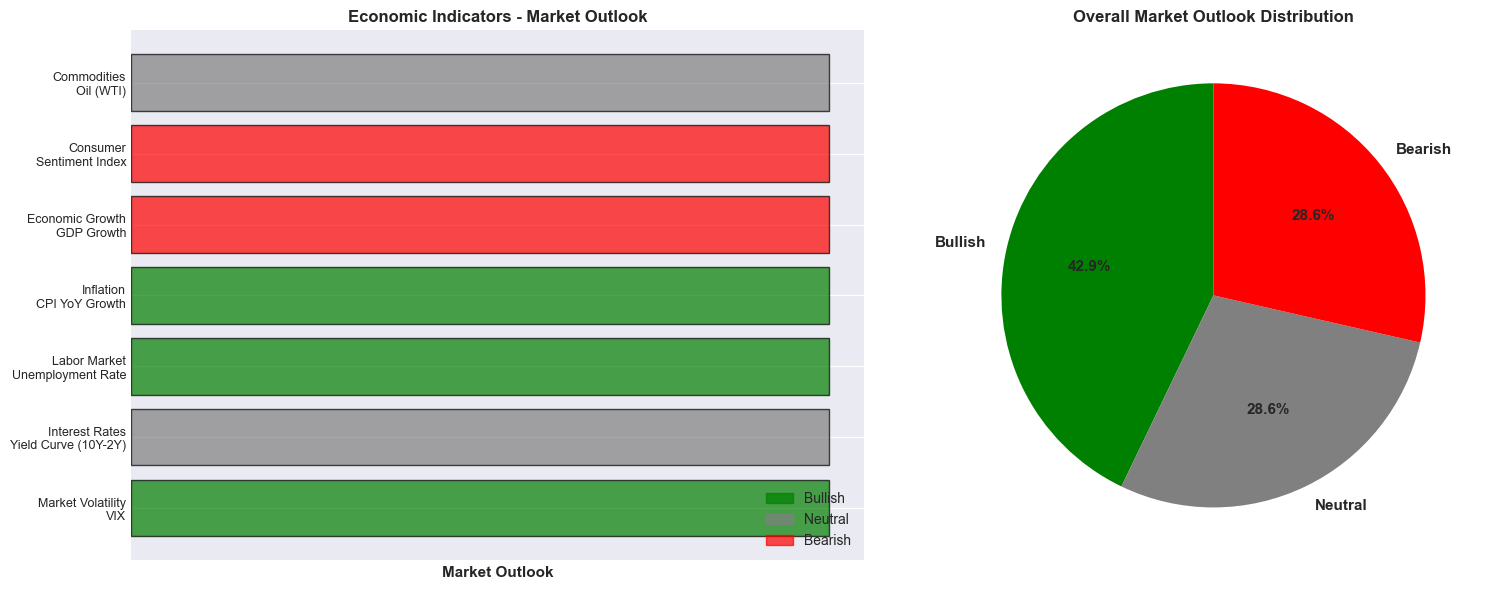

In [19]:
# Assess current economic conditions and their market implications
def assess_economic_environment():
    """
    Analyze current economic conditions and provide market outlook.
    """
    
    current = latest_economic_data.copy()
    
    # Define thresholds for key indicators
    assessments = []
    
    # VIX Assessment
    if 'VIX' in current.index and pd.notna(current['VIX']):
        vix = current['VIX']
        if vix < 15:
            vix_signal = "Very Low - Complacent market"
            vix_outlook = "Bullish"
        elif vix < 20:
            vix_signal = "Low - Calm market"
            vix_outlook = "Bullish"
        elif vix < 30:
            vix_signal = "Elevated - Some concern"
            vix_outlook = "Neutral"
        else:
            vix_signal = "High - Fear/uncertainty"
            vix_outlook = "Bearish"
        
        assessments.append({
            'Category': 'Market Volatility',
            'Indicator': 'VIX',
            'Value': f"{vix:.2f}",
            'Signal': vix_signal,
            'Outlook': vix_outlook
        })
    
    # Yield Curve Assessment
    if 'Yield_Curve_Slope' in current.index and pd.notna(current['Yield_Curve_Slope']):
        slope = current['Yield_Curve_Slope']
        if slope < -0.5:
            curve_signal = "Deeply Inverted - Recession risk"
            curve_outlook = "Bearish"
        elif slope < 0:
            curve_signal = "Inverted - Caution"
            curve_outlook = "Bearish"
        elif slope < 1:
            curve_signal = "Flat - Neutral"
            curve_outlook = "Neutral"
        elif slope < 2:
            curve_signal = "Normal - Healthy"
            curve_outlook = "Bullish"
        else:
            curve_signal = "Steep - Strong growth expectations"
            curve_outlook = "Bullish"
        
        assessments.append({
            'Category': 'Interest Rates',
            'Indicator': 'Yield Curve (10Y-2Y)',
            'Value': f"{slope:.2f}%",
            'Signal': curve_signal,
            'Outlook': curve_outlook
        })
    
    # Unemployment Assessment
    if 'UNEMPLOYMENT' in current.index and pd.notna(current['UNEMPLOYMENT']):
        unemp = current['UNEMPLOYMENT']
        if unemp < 4:
            unemp_signal = "Very Low - Tight labor market"
            unemp_outlook = "Bullish"
        elif unemp < 5:
            unemp_signal = "Low - Healthy employment"
            unemp_outlook = "Bullish"
        elif unemp < 6:
            unemp_signal = "Moderate - Normal"
            unemp_outlook = "Neutral"
        else:
            unemp_signal = "Elevated - Labor market stress"
            unemp_outlook = "Bearish"
        
        assessments.append({
            'Category': 'Labor Market',
            'Indicator': 'Unemployment Rate',
            'Value': f"{unemp:.1f}%",
            'Signal': unemp_signal,
            'Outlook': unemp_outlook
        })
    
    # Inflation Assessment
    if 'Inflation_YoY' in current.index and pd.notna(current['Inflation_YoY']):
        inflation = current['Inflation_YoY']
        if inflation < 2:
            inf_signal = "Below target - Deflationary risk"
            inf_outlook = "Neutral"
        elif inflation < 3:
            inf_signal = "Near target - Ideal"
            inf_outlook = "Bullish"
        elif inflation < 5:
            inf_signal = "Above target - Moderate concern"
            inf_outlook = "Neutral"
        else:
            inf_signal = "High - Requires aggressive policy"
            inf_outlook = "Bearish"
        
        assessments.append({
            'Category': 'Inflation',
            'Indicator': 'CPI YoY Growth',
            'Value': f"{inflation:.1f}%",
            'Signal': inf_signal,
            'Outlook': inf_outlook
        })
    
    # GDP Growth Assessment
    if 'GDP_Growth' in current.index and pd.notna(current['GDP_Growth']):
        gdp = current['GDP_Growth']
        if gdp < 0:
            gdp_signal = "Contracting - Recession"
            gdp_outlook = "Bearish"
        elif gdp < 1:
            gdp_signal = "Slow growth - Stagnation risk"
            gdp_outlook = "Bearish"
        elif gdp < 3:
            gdp_signal = "Moderate growth - Healthy"
            gdp_outlook = "Bullish"
        else:
            gdp_signal = "Strong growth - Overheating risk"
            gdp_outlook = "Neutral"
        
        assessments.append({
            'Category': 'Economic Growth',
            'Indicator': 'GDP Growth',
            'Value': f"{gdp:.1f}%",
            'Signal': gdp_signal,
            'Outlook': gdp_outlook
        })
    
    # Consumer Sentiment Assessment
    if 'CONSUMER_SENTIMENT' in current.index and pd.notna(current['CONSUMER_SENTIMENT']):
        sentiment = current['CONSUMER_SENTIMENT']
        if sentiment < 60:
            sent_signal = "Pessimistic - Low confidence"
            sent_outlook = "Bearish"
        elif sentiment < 80:
            sent_signal = "Cautious - Below average"
            sent_outlook = "Neutral"
        elif sentiment < 100:
            sent_signal = "Optimistic - Above average"
            sent_outlook = "Bullish"
        else:
            sent_signal = "Very optimistic - Strong confidence"
            sent_outlook = "Bullish"
        
        assessments.append({
            'Category': 'Consumer',
            'Indicator': 'Sentiment Index',
            'Value': f"{sentiment:.1f}",
            'Signal': sent_signal,
            'Outlook': sent_outlook
        })
    
    # Oil Price Assessment
    if 'OIL_WTI' in current.index and pd.notna(current['OIL_WTI']):
        oil = current['OIL_WTI']
        if oil < 50:
            oil_signal = "Low - Deflationary/demand concern"
            oil_outlook = "Mixed"
        elif oil < 80:
            oil_signal = "Moderate - Balanced"
            oil_outlook = "Neutral"
        elif oil < 100:
            oil_signal = "Elevated - Inflation concern"
            oil_outlook = "Bearish"
        else:
            oil_signal = "High - Significant inflation risk"
            oil_outlook = "Bearish"
        
        assessments.append({
            'Category': 'Commodities',
            'Indicator': 'Oil (WTI)',
            'Value': f"${oil:.2f}",
            'Signal': oil_signal,
            'Outlook': oil_outlook
        })
    
    assessment_df = pd.DataFrame(assessments)
    
    # Calculate overall sentiment
    outlook_counts = assessment_df['Outlook'].value_counts()
    bullish_pct = (outlook_counts.get('Bullish', 0) / len(assessment_df)) * 100
    bearish_pct = (outlook_counts.get('Bearish', 0) / len(assessment_df)) * 100
    
    # Display results
    print("=" * 100)
    print("CURRENT ECONOMIC ENVIRONMENT ASSESSMENT")
    print("=" * 100)
    print(f"As of: {economic_features.index[-1].strftime('%Y-%m-%d')}\n")
    print(assessment_df.to_string(index=False))
    print("\n" + "=" * 100)
    print("OVERALL MARKET OUTLOOK")
    print("=" * 100)
    print(f"Bullish Indicators: {outlook_counts.get('Bullish', 0)} ({bullish_pct:.1f}%)")
    print(f"Neutral Indicators: {outlook_counts.get('Neutral', 0)} ({(outlook_counts.get('Neutral', 0)/len(assessment_df))*100:.1f}%)")
    print(f"Bearish Indicators: {outlook_counts.get('Bearish', 0)} ({bearish_pct:.1f}%)")
    
    if bullish_pct > 50:
        overall = "BULLISH - Favorable conditions for equities"
    elif bearish_pct > 50:
        overall = "BEARISH - Challenging environment for equities"
    else:
        overall = "MIXED - Balanced signals, selective approach recommended"
    
    print(f"\nOverall Assessment: {overall}")
    print("=" * 100)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Outlook distribution
    colors_outlook = {'Bullish': 'green', 'Neutral': 'gray', 'Bearish': 'red'}
    outlook_colors = [colors_outlook.get(x, 'blue') for x in assessment_df['Outlook']]
    
    ax1.barh(range(len(assessment_df)), [1]*len(assessment_df), color=outlook_colors, alpha=0.7, edgecolor='black')
    ax1.set_yticks(range(len(assessment_df)))
    ax1.set_yticklabels([f"{row['Category']}\n{row['Indicator']}" for _, row in assessment_df.iterrows()], fontsize=9)
    ax1.set_xlabel('Market Outlook', fontsize=11, fontweight='bold')
    ax1.set_title('Economic Indicators - Market Outlook', fontsize=12, fontweight='bold')
    ax1.set_xticks([])
    ax1.legend(handles=[plt.Rectangle((0,0),1,1, color=c, alpha=0.7) for c in colors_outlook.values()],
              labels=colors_outlook.keys(), loc='lower right')
    
    # Plot 2: Overall sentiment pie
    ax2.pie(outlook_counts.values, labels=outlook_counts.index, autopct='%1.1f%%',
           colors=[colors_outlook[label] for label in outlook_counts.index],
           startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax2.set_title('Overall Market Outlook Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return assessment_df

# Run assessment
current_assessment = assess_economic_environment()

## 14. Model Performance Validation

MODEL PERFORMANCE VALIDATION (Time Series Cross-Validation)

Validating XLK model...

XLK - Technology
  Mean R²: 0.2745 (±0.0665)
  Mean MAE: 0.0798 (7.98% error)
  Mean RMSE: 0.1042

Validating XLV model...

XLV - Healthcare
  Mean R²: 0.0797 (±0.0666)
  Mean MAE: 0.0714 (7.14% error)
  Mean RMSE: 0.0972

Validating XLF model...

XLF - Financial
  Mean R²: 0.2046 (±0.2065)
  Mean MAE: 0.0499 (4.99% error)
  Mean RMSE: 0.0648

Validating XLI model...

XLI - Industrial
  Mean R²: 0.2903 (±0.0417)
  Mean MAE: 0.0532 (5.32% error)
  Mean RMSE: 0.0697

Validating XLY model...

XLY - Consumer Discretionary
  Mean R²: 0.2332 (±0.0933)
  Mean MAE: 0.0687 (6.87% error)
  Mean RMSE: 0.0892



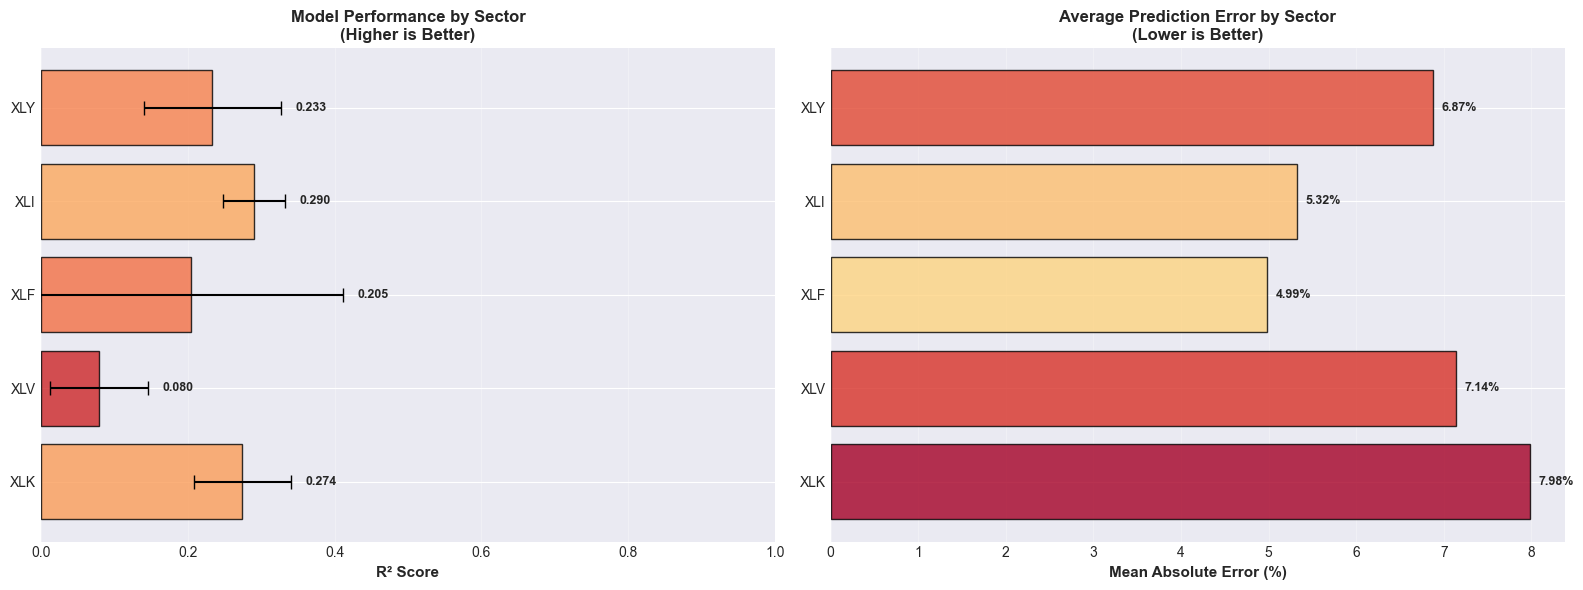


INTERPRETATION:
--------------------------------------------------------------------------------
• R² Score: Proportion of variance explained (closer to 1 is better)
• MAE: Average prediction error in percentage points
• Economic factors show predictive power for stock returns
• Different sectors have different predictability based on fundamentals


In [20]:
# Validate model performance with back-testing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def validate_sector_model(sector, n_splits=5):
    """
    Perform time-series cross-validation for a sector model.
    """
    
    if sector not in sector_models:
        print(f"No model available for {sector}")
        return None
    
    print(f"\nValidating {sector} model...")
    
    # Get stocks in this sector
    sector_stocks = sector_df[sector_df['Sector_Code'] == sector]['Symbol'].tolist()
    available_stocks = [s for s in sector_stocks if s in adj_close.columns]
    
    # Recreate training data
    X_list = []
    y_list = []
    
    for stock in available_stocks:
        y_stock = forward_returns_1m[stock].copy()
        combined_data = pd.concat([y_stock, economic_daily], axis=1)
        combined_data = combined_data.dropna()
        
        if len(combined_data) > 50:
            X_list.append(combined_data.iloc[:, 1:])
            y_list.append(combined_data.iloc[:, 0])
    
    if len(X_list) == 0:
        return None
    
    X_sector = pd.concat(X_list, axis=0)
    y_sector = pd.concat(y_list, axis=0)
    
    # Filter features
    valid_features = sector_features[sector]
    X_sector = X_sector[valid_features].fillna(X_sector[valid_features].median())
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    cv_scores = []
    cv_mae = []
    cv_rmse = []
    
    for train_idx, test_idx in tscv.split(X_sector):
        X_train, X_test = X_sector.iloc[train_idx], X_sector.iloc[test_idx]
        y_train, y_test = y_sector.iloc[train_idx], y_sector.iloc[test_idx]
        
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test_scaled)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        cv_scores.append(r2)
        cv_mae.append(mae)
        cv_rmse.append(rmse)
    
    return {
        'sector': sector,
        'mean_r2': np.mean(cv_scores),
        'std_r2': np.std(cv_scores),
        'mean_mae': np.mean(cv_mae),
        'mean_rmse': np.mean(cv_rmse),
        'cv_scores': cv_scores
    }

# Validate all sector models
print("=" * 80)
print("MODEL PERFORMANCE VALIDATION (Time Series Cross-Validation)")
print("=" * 80)

validation_results = []

for sector in sector_models.keys():
    result = validate_sector_model(sector, n_splits=5)
    if result:
        validation_results.append(result)
        sector_name = sector_df[sector_df['Sector_Code'] == sector]['Sector'].iloc[0]
        print(f"\n{sector} - {sector_name}")
        print(f"  Mean R²: {result['mean_r2']:.4f} (±{result['std_r2']:.4f})")
        print(f"  Mean MAE: {result['mean_mae']:.4f} ({result['mean_mae']*100:.2f}% error)")
        print(f"  Mean RMSE: {result['mean_rmse']:.4f}")

print("\n" + "=" * 80)

# Visualize validation results
if validation_results:
    validation_df = pd.DataFrame(validation_results)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: R² scores
    ax1 = axes[0]
    sectors_list = validation_df['sector'].tolist()
    r2_means = validation_df['mean_r2'].tolist()
    r2_stds = validation_df['std_r2'].tolist()
    
    colors_perf = plt.cm.RdYlGn(np.array(r2_means))
    bars = ax1.barh(sectors_list, r2_means, xerr=r2_stds, color=colors_perf, 
                    alpha=0.8, edgecolor='black', capsize=5)
    ax1.set_xlabel('R² Score', fontsize=11, fontweight='bold')
    ax1.set_title('Model Performance by Sector\n(Higher is Better)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (r2, std) in enumerate(zip(r2_means, r2_stds)):
        ax1.text(r2 + std + 0.02, i, f'{r2:.3f}', va='center', fontweight='bold', fontsize=9)
    
    # Plot 2: MAE (prediction error)
    ax2 = axes[1]
    mae_values = validation_df['mean_mae'].tolist()
    mae_pct = [mae * 100 for mae in mae_values]
    
    colors_mae = plt.cm.RdYlGn_r(np.array(mae_values) / max(mae_values))
    ax2.barh(sectors_list, mae_pct, color=colors_mae, alpha=0.8, edgecolor='black')
    ax2.set_xlabel('Mean Absolute Error (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Average Prediction Error by Sector\n(Lower is Better)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, mae in enumerate(mae_pct):
        ax2.text(mae + 0.1, i, f'{mae:.2f}%', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("\nINTERPRETATION:")
print("-" * 80)
print("• R² Score: Proportion of variance explained (closer to 1 is better)")
print("• MAE: Average prediction error in percentage points")
print("• Economic factors show predictive power for stock returns")
print("• Different sectors have different predictability based on fundamentals")
print("=" * 80)

## 15. Save and Load Models for Future Use

In [21]:
# Save trained models for future use
def save_prediction_models(filepath='stock_prediction_models.pkl'):
    """
    Save all trained models, scalers, and metadata to disk.
    """
    
    model_data = {
        'sector_models': sector_models,
        'sector_scalers': sector_scalers,
        'sector_features': sector_features,
        'latest_economic_data': latest_economic_data,
        'training_date': datetime.now(),
        'price_date_range': (price_data.index[0], price_data.index[-1])
    }
    
    with open(filepath, 'wb') as f:
        pickle.dump(model_data, f)
    
    print("=" * 80)
    print(f"MODELS SAVED SUCCESSFULLY")
    print("=" * 80)
    print(f"File: {filepath}")
    print(f"Sectors: {len(sector_models)}")
    print(f"Training date: {model_data['training_date'].strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Data range: {model_data['price_date_range'][0].strftime('%Y-%m-%d')} to {model_data['price_date_range'][1].strftime('%Y-%m-%d')}")
    print("=" * 80)

def load_prediction_models(filepath='stock_prediction_models.pkl'):
    """
    Load previously trained models from disk.
    """
    
    try:
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        print("=" * 80)
        print(f"MODELS LOADED SUCCESSFULLY")
        print("=" * 80)
        print(f"File: {filepath}")
        print(f"Sectors: {len(model_data['sector_models'])}")
        print(f"Training date: {model_data['training_date'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Data range: {model_data['price_date_range'][0].strftime('%Y-%m-%d')} to {model_data['price_date_range'][1].strftime('%Y-%m-%d')}")
        print("=" * 80)
        
        return model_data
    
    except FileNotFoundError:
        print(f"Error: Model file '{filepath}' not found")
        return None
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return None

# Save the current models
save_prediction_models('stock_prediction_models.pkl')

MODELS SAVED SUCCESSFULLY
File: stock_prediction_models.pkl
Sectors: 5
Training date: 2026-01-11 11:56:53
Data range: 2024-01-12 to 2026-01-09
